# Monthly Mean Temp

### 1. Análisis exploratorio

En este paso se analiza la serie de tiempo correspondiente a la temperatura media mensual, comenzando en enero de 1920.

- La serie contiene datos mensuales en grados Fahrenheit.
- Se transformó la columna de fechas al tipo "datetime" para facilitar su análisis y visualización.
- A través de un gráfico de líneas se puede observar la variación estacional en las temperaturas, con subidas y bajadas que se repiten de forma cíclica cada año.

Este análisis inicial nos permite conocer la estructura del conjunto de datos, su rango temporal y los patrones generales.

Información del DataFrame:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 1920-01-01 to 1939-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB
None

Primeras filas:

            Temperature
Month                  
1920-01-01         40.6
1920-02-01         40.8
1920-03-01         44.4
1920-04-01         46.7
1920-05-01         54.1

Estadísticas descriptivas:

       Temperature
count   240.000000
mean     49.041250
std       8.569705
min      31.300000
25%      41.550000
50%      47.350000
75%      57.000000
max      66.500000

Rango de fechas:
1920-01-01  →  1939-12-01


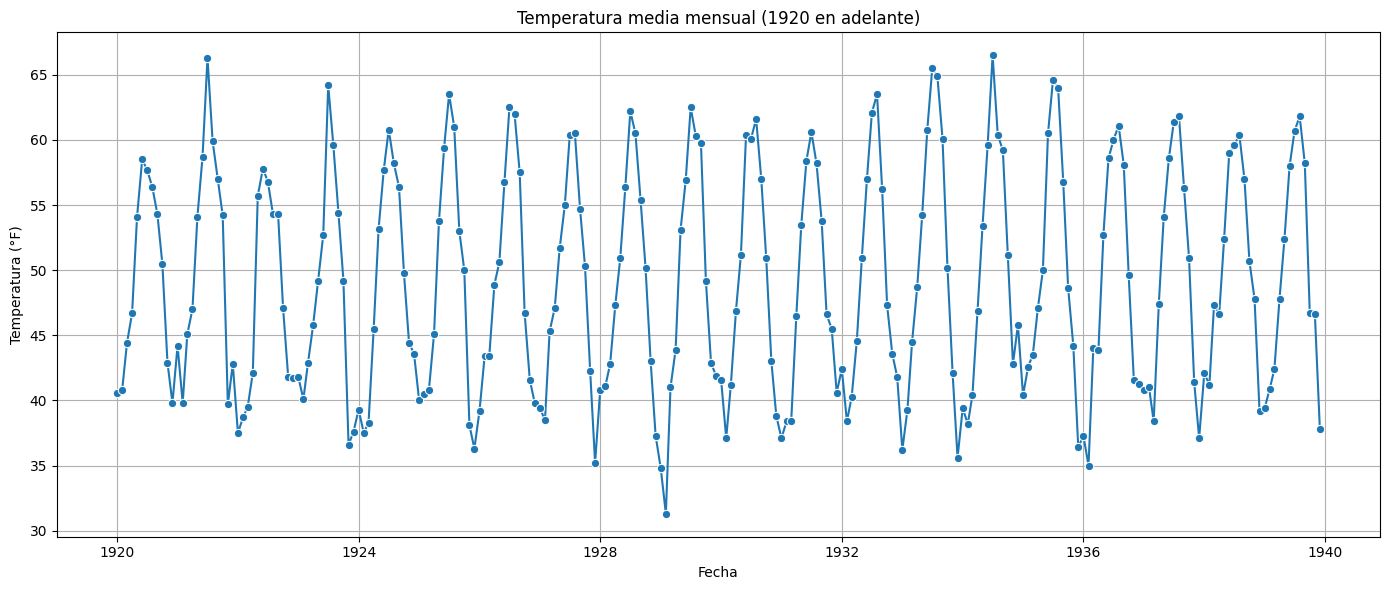

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("monthly-mean-temp.csv")
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

print("Información del DataFrame:\n")
print(df.info())
print("\nPrimeras filas:\n")
print(df.head())
print("\nEstadísticas descriptivas:\n")
print(df.describe())
print("\nRango de fechas:")
print(f"{df.index.min().date()}  →  {df.index.max().date()}")

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x=df.index, y='Temperature', marker='o')
plt.title("Temperatura media mensual (1920 en adelante)")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°F)")
plt.grid(True)
plt.tight_layout()
plt.show()


### 2. Promedios Móviles

Se aplicaron dos métodos de promedio móvil para suavizar la serie:

- Media Móvil de 6 meses: reduce la variación mensual y suaviza fluctuaciones de corto plazo.
- Media Móvil de 12 meses: proporciona una vista más general del comportamiento anual.

Ambas ayudan a identificar patrones estacionales y tendencias a largo plazo, eliminando parte del "ruido" en los datos originales. Como se observa en el gráfico, la media móvil de 12 meses es más suave y sigue de manera más estable la tendencia central.

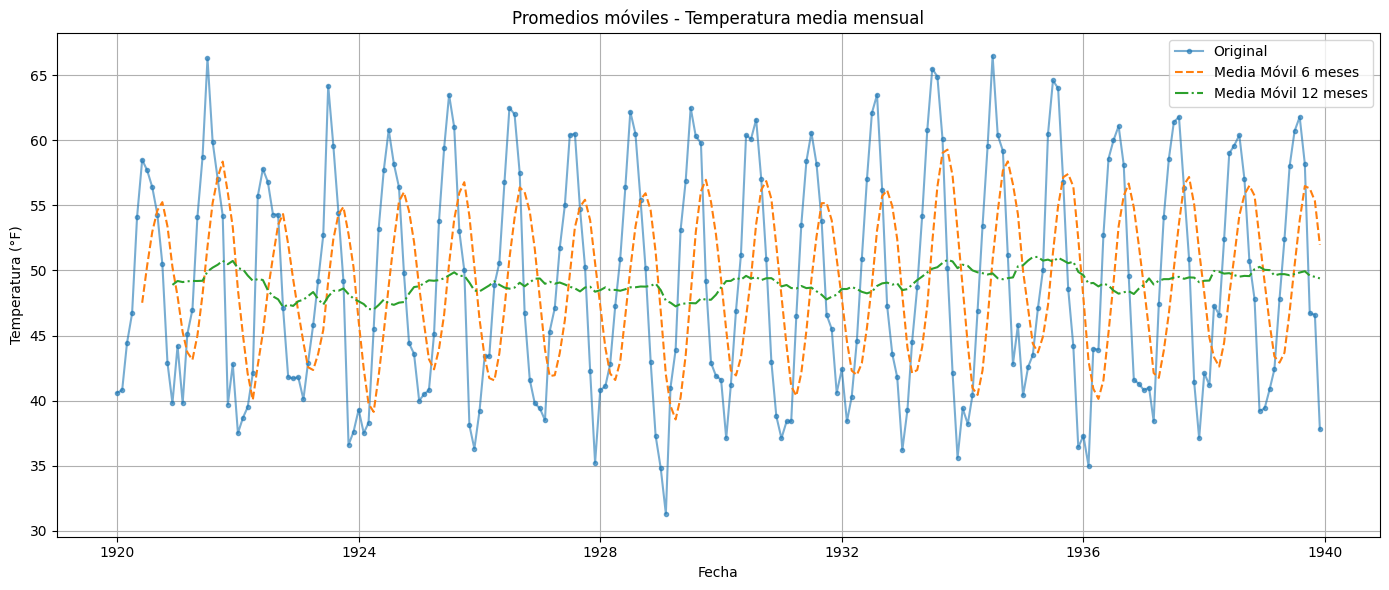

In [3]:
df['Media_Movil_6'] = df['Temperature'].rolling(window=6).mean()
df['Media_Movil_12'] = df['Temperature'].rolling(window=12).mean()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Temperature'], label='Original', marker='o', markersize=3, alpha=0.6)
plt.plot(df.index, df['Media_Movil_6'], label='Media Móvil 6 meses', linestyle='--')
plt.plot(df.index, df['Media_Movil_12'], label='Media Móvil 12 meses', linestyle='-.')
plt.title("Promedios móviles - Temperatura media mensual")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 3. Alisamiento exponencial

Se aplicó un modelo de alisamiento exponencial simple con un valor de suavizado α = 0.2 para filtrar las variaciones bruscas en la temperatura.

Este método:
- Da más peso a los valores recientes.
- Ayuda a visualizar la tendencia general sin perder completamente los detalles de la serie.
- Es útil cuando no hay una estacionalidad fuerte o no se quiere modelarla aún.

Como se observa en la gráfica, la curva suavizada sigue el patrón general de la serie, pero sin tantos picos ni caídas bruscas.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


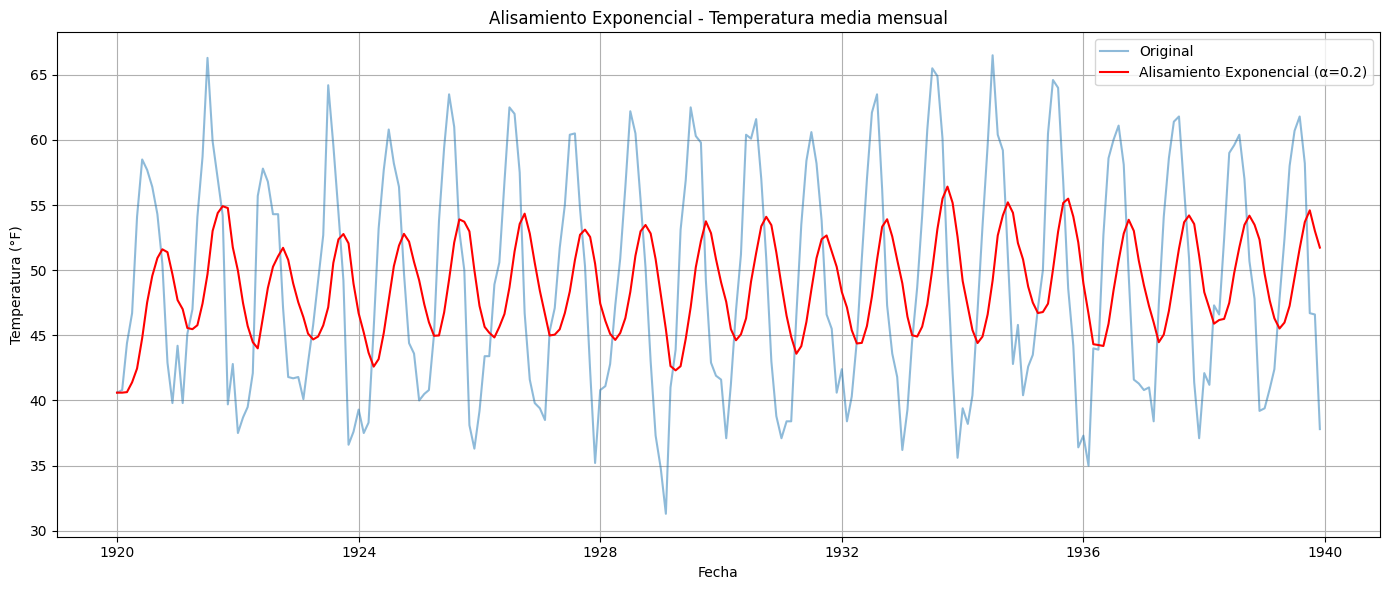

In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(df['Temperature']).fit(smoothing_level=0.2, optimized=False)
df['Exponencial'] = model.fittedvalues

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Temperature'], label='Original', alpha=0.5)
plt.plot(df.index, df['Exponencial'], label='Alisamiento Exponencial (α=0.2)', color='red')
plt.title("Alisamiento Exponencial - Temperatura media mensual")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 4. HOLT-WINTERS

Se aplicó el modelo de Holt-Winters con:

- Tendencia aditiva
- Estacionalidad aditiva
- Periodo estacional de 12 meses (ciclo anual)

Este modelo es útil para series que muestran tendencia y estacionalidad, como es el caso de las temperaturas mensuales. 

Como se observa en la gráfica, el modelo logra seguir tanto el aumento/disminución de la temperatura como los ciclos repetitivos anuales.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


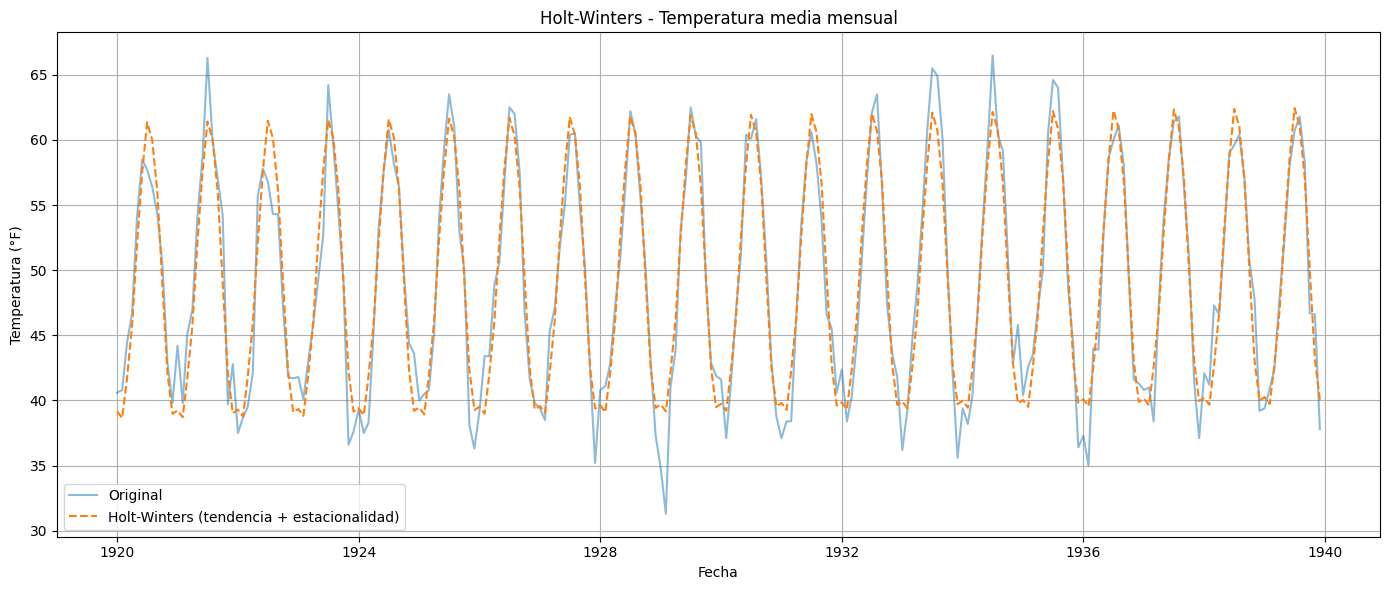

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(df['Temperature'], trend='add', seasonal='add', seasonal_periods=12).fit()
df['HoltWinters'] = model_hw.fittedvalues

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Temperature'], label='Original', alpha=0.5)
plt.plot(df.index, df['HoltWinters'], label='Holt-Winters (tendencia + estacionalidad)', linestyle='--')
plt.title("Holt-Winters - Temperatura media mensual")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 5. SARIMA

Se utilizó un modelo SARIMA con parámetros comunes:

- order = (1, 1, 1)
- seasonal_order = (1, 1, 1, 12)

Este modelo permite capturar tanto la tendencia como la estacionalidad mensual de la serie. Aunque los parámetros no fueron ajustados automáticamente, estos valores suelen funcionar bien para series con ciclos anuales.

El gráfico muestra que SARIMA sigue el patrón general de las temperaturas y sus repeticiones estacionales.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


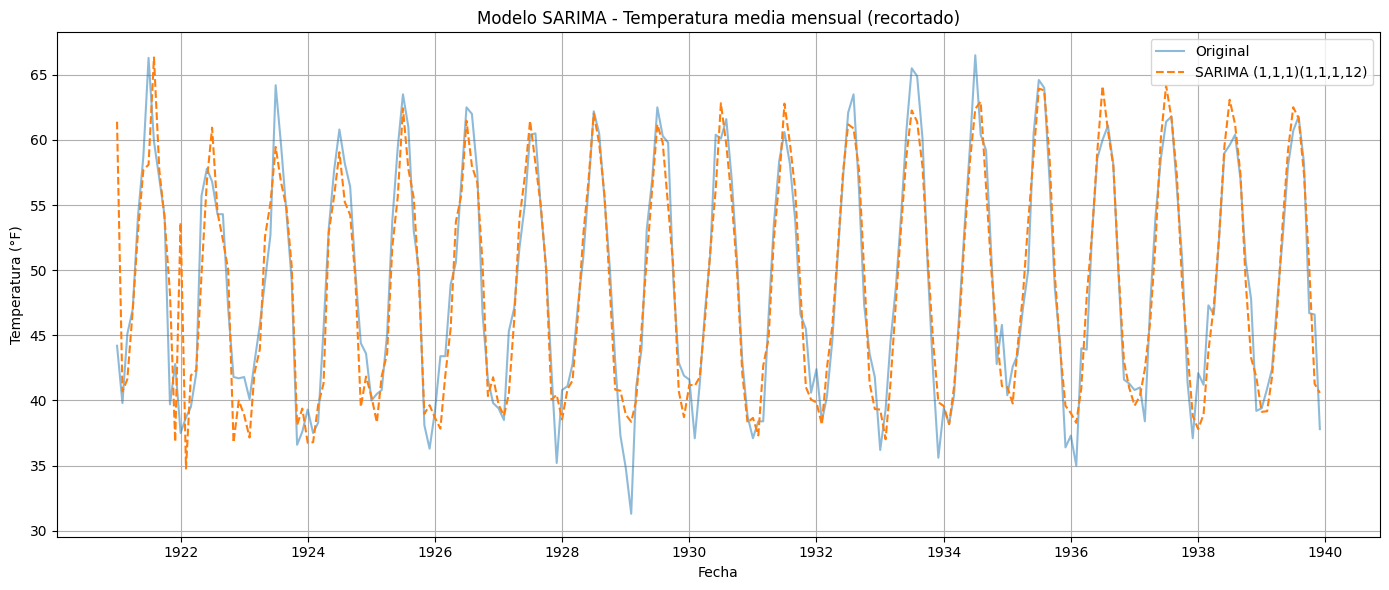

In [12]:
import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(
    df['Temperature'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

df['SARIMA'] = sarima_model.fittedvalues
df_sarima = df[12:]

plt.figure(figsize=(14, 6))
plt.plot(df_sarima.index, df_sarima['Temperature'], label='Original', alpha=0.5)
plt.plot(df_sarima.index, df_sarima['SARIMA'], label='SARIMA (1,1,1)(1,1,1,12)', linestyle='--')
plt.title("Modelo SARIMA - Temperatura media mensual (recortado)")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 6. Prophet

Se utilizó el modelo Prophet desarrollado por Facebook para predecir la temperatura media mensual.

Este modelo es capaz de detectar tendencias y estacionalidades automáticamente. Además, permite hacer predicciones a futuro de forma sencilla. En este caso, se generaron 12 meses adicionales.

La gráfica muestra tanto el ajuste sobre los datos históricos como la proyección futura.

19:45:12 - cmdstanpy - INFO - Chain [1] start processing
19:45:12 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/lib/python3.11/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


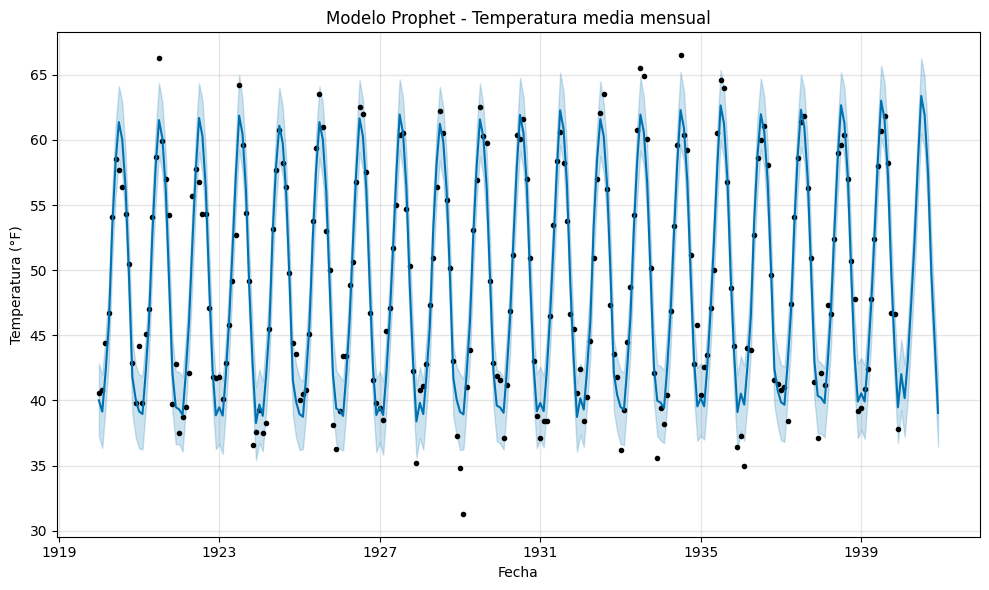

In [14]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

df_prophet = df.reset_index()[['Month', 'Temperature']].rename(columns={'Month': 'ds', 'Temperature': 'y'})
modelo_prophet = Prophet()
modelo_prophet.fit(df_prophet)
futuro = modelo_prophet.make_future_dataframe(periods=12, freq='M')
forecast = modelo_prophet.predict(futuro)

modelo_prophet.plot(forecast)
plt.title("Modelo Prophet - Temperatura media mensual")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°F)")
plt.tight_layout()
plt.grid(True)
plt.show()


### 7. Comparación y Evaluación

Para evaluar los modelos se usaron dos métricas comunes:

- **RMSE (Root Mean Squared Error)**: mide el error promedio cuadrático entre los valores reales y los predichos.
- **MAE (Mean Absolute Error)**: mide el error absoluto promedio.

Se compararon los modelos:

- Promedios Móviles
- Alisamiento Exponencial
- Holt-Winters
- SARIMA
- Prophet

El modelo con menor RMSE y MAE es el que mejor se ajusta a los datos. También es importante observar la gráfica para ver si sigue bien la forma de la serie.